# MIS 583 Assignment 6 Part 2: Image Captioning with Attention



Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 陳琨翔, M094020003

**Your Answer:**   
Hi I'm 李畇彤, M114020038

## Image Captioning with Attention

The use of Attention networks is widespread in deep learning, and with good reason. This is a way for a model to choose only those parts of the encoding that it thinks is relevant to the task at hand. The same mechanism you see employed here can be used in any model where the Encoder's output has multiple points in space or time. In image captioning, you consider some pixels more important than others. In sequence to sequence tasks like machine translation, you consider some words more important than others.

In the assignment, you will design and train a Image captioning network with Attention mechanism from scratch to process the input image, then output a sequence that describe the image. 

**Note that you are free to use pre-trained models like ResNet or LSTM as your backbone structure.**

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.

In [1]:
!nvidia-smi

Tue Dec 20 15:51:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    56W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.8.16 (default, Dec  7 2022, 01:12:13) 
torch 1.13.0+cu116
torchvision 0.14.0+cu116


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

For reference, we use [Flickr8k](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb) dataset.
This dataset is collected by Alexander Mamaev.

**Abstrct**  
A new benchmark collection for sentence-based image description and search, consisting of 8,091 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

Photos are not reduced to a single size, they have different proportions!





## How to Get Data

Please open the file `flickr8k.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1awvS-E5IPMJgu6kiRjZbiwyrmx6Cl6VO/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `flickr8k.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1awvS-E5IPMJgu6kiRjZbiwyrmx6Cl6VO/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip Data

Unzip `flickr8k.zip`, there are 2 folders and 1 txt.

- `images/`: contains images for training.
- `test_examples/`: contains images for testing.
- `captions.txt`: the file_names and their captions.

There are **8091 images in images.**  
There are **5 images in test_examples.**   

---

解壓縮 `flickr8k.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `images` : 訓練用圖片。
+ `test_examples` : 測試結果用的圖片。
+ `captions.txt` : 圖片檔名及對應的敘述。

其中`images`的圖片  8091 張，`test_examples` 的圖片 5 張

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [4]:
!unzip -qq ./drive/MyDrive/NSYSU/Deep_Learning/MIS583/flickr8k.zip

In [5]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1 Data Processing & DataLoader

In [6]:
# Download with: python -m spacy download en 
# the tokenize
spacy_eng = spacy.load("en_core_web_sm")

In [7]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #some index to string
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3} #some string to index
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] #lowercase all the words
        # "I like Deep Learning" >>> ["i", "like", "deep", "learning"]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 # 0-3 have already been used

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [8]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [9]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = False, padding_value = self.pad_idx)

        return imgs, targets

In [10]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size = 32,
    num_workers = 8,
    shuffle = True,
    pin_memory = True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform = transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory,
        collate_fn = MyCollate(pad_idx = pad_idx),
    )

    return loader, dataset


## Your Turn: Design Your Augmentation(5 points)

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)



In [11]:
######################################################################################
#  TODO: use transforms.xxx method to do some data augmentation       #
#  This one is for training, find the composition to get better result  #
######################################################################################
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
  ])
########################################################################
#             End of your code              #
########################################################################

In [12]:
train_loader, dataset = get_loader(
  root_folder="flickr8k/images/",
  annotation_file="flickr8k/captions.txt",
  transform=transform,
  num_workers=0,
)

########################
dataL = iter(train_loader)
imgs, captions = next(dataL)
print("Shape of the imgs : ", imgs.shape)
print("Shape of the captions : ", captions.shape)

Shape of the imgs :  torch.Size([32, 3, 224, 224])
Shape of the captions :  torch.Size([22, 32])


# Build Your Model Structure


<a id='step3'></a>
## Step 2(Your Turn): Implement the CNN Encoder(10 points)


You can use pre-trained models like ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. 

In the code cell below, `features` should be a PyTorch tensor with size `[batch_size, num_pixels, encoder_dim]`.

Ex.if your pretrained model is resnet50, your output `features` should be the size of `[batch_size, 49, 2048]`.

In [13]:
class EncoderAttentionCNN(nn.Module):
    def __init__(self):
        super(EncoderAttentionCNN, self).__init__()
        ######################################################################################
        #  TODO: TODO: Design your CNN model structure                 #
        ######################################################################################
        model = models.resnet101(pretrained=True)
        modules = list(model.children())[:-2]
        self.pretrain = nn.Sequential(*modules)
        for param in list(self.pretrain.children())[:-3]:
            param.requires_grad_(False)

        ########################################################################
        #             End of your code              #
        ########################################################################

    def forward(self, images):

        ######################################################################################
        #  TODO: TODO: Design your CNN forward method                 #
        ######################################################################################
        features = self.pretrain(images)
        features = features.view(features.shape[0] ,features.shape[1], -1)
        output = features.permute(0, 2, 1)

        ########################################################################
        #             End of your code              #
        ########################################################################

        return output #(batch_size, num_pixels, encoder_dim) ,if pretrained = resnet50: (batch_size ,49, 2048)

<a id='step4'></a>
## Step 3(Your Turn):  Implement Attention Module(15 points)

In this part, you should design Attention Module.

In the code cell below, the output `alpha` should be a PyTorch tensor with size `[batch_size, num_pixels]`, and the output `attention_weights` should be a PyTorch tensor with size `[batch_size, encoder_dim]`.  

In [14]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim

        ######################################################################################
        #  TODO: Design your Attention layers                       #
        #  The layers should be some Linear layers                   #
        ######################################################################################
        
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 
        self.encoder_att = nn.Linear(encoder_dim, attention_dim) 
        
        self.full_att = nn.Linear(attention_dim, 1)

        ########################################################################
        #             End of your code              #
        ########################################################################
        
    def forward(self, features, hidden_state):
      # features (batch_size, num_pixels, encoder_dim)
      # hidden_state (batch_size, decoder_dim)
        
        ######################################################################################
        #  TODO: Design the forward method of your Attention module         #
        ######################################################################################

        atten_1 = self.encoder_att(features) 
        #(batch_size, num_pixels, attention_dim)
        atten_2 = self.decoder_att(hidden_state) 
        #(batch_size, attention_dim)
        
        combined_atten = self.full_att(F.relu(atten_1 + atten_2.unsqueeze(1))).squeeze(2)
        #(batch_size, num_pixels, attemtion_dim) 

        alpha = F.softmax(combined_atten, dim=1)
        #(batch_size, num_pixels)
        
        attention_weights = (features * alpha.unsqueeze(2)).sum(dim=1)
        #(batch_size, features_dim)

        ########################################################################
        #             End of your code              #
        ########################################################################
        
        return alpha, attention_weights   # alpha:(batch_size, num_pixels)  attention_weights:#(batch_size, features_dim)

<a id='step4'></a>
## Step 4(Your Turn):  Implement the Attention RNN Decoder(10 points)

In this part, you should design your Attention RNN Decoder.

For Attention RNN Decoder, the iteration is performed manually in a for loop with a PyTorch `LSTMCell` instead of iterating automatically without a loop with a PyTorch `LSTM`. This is because we need to execute the Attention mechanism between each decode step. An `LSTMCell` is a single timestep operation, whereas an `LSTM` would iterate over multiple timesteps continously and provide all outputs at once.


In [15]:
#Attention Decoder
class DecoderAttentionRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.encoder_dim = encoder_dim
        
        ######################################################################################
        #  TODO: Design your DecoderAttentionRNN layers                 #
        #  The LSTM layer should be nn.LSTMCell instead of nn.LSTM         #
        ######################################################################################

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        ########################################################################
        #             End of your code              #
        ########################################################################
        
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        
        self.drop = nn.Dropout(drop_prob)

    def init_hidden_state(self, encoder_out):
        # encoder_out (batch_size, num_pixels, encoder_dim)

        mean_encoder_out = encoder_out.mean(dim=1)
        # mean_encoder_out (batch_size, encoder_dim)
        
        ############################################################################################
        #  TODO: Use the init_h & init_c layers to get the hidden_state and the cell #
        ############################################################################################

        h = self.init_h(mean_encoder_out)
        # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        # (batch_size, decoder_dim)

        ########################################################################
        #             End of your code              #
        ########################################################################
        return h, c

    def forward(self, features, captions):
        
        ######################################################################################
        #  TODO: Design the forward method of your Attention RNNDecoder       #
        #  You shoud first embed the captions                      #
        #  Then draw the hidden_state and the cell from the image features    #
        ######################################################################################
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)
        # both are the size of (batch_size, decoder_dim) 

        ########################################################################
        #             End of your code              #
        ########################################################################
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            
            ######################################################################################
            #  TODO: Get the attention output from the attention module         #
            ######################################################################################
            alpha, attention_weight = self.attention(features, h)
            ########################################################################
            #             End of your code              #
            ########################################################################
            
            lstm_input = torch.cat((embeds[:, s], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas


    #Testing Phase
    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)

        ######################################################################################
        #  TODO: Initialize the LSTM state with the same method in training phase            #
        #  draw the hidden_state and the cell from the image features                        #
        ######################################################################################
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)
        # both are the size of (batch_size, decoder_dim)

        ########################################################################
        #             End of your code              #
        ########################################################################
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        
        captions = []
        
        for i in range(max_len):

            ######################################################################################
            #  TODO: Get the attention output from the attention module         #
            ######################################################################################
            alpha, attention_weight = self.attention(features, h)
            ########################################################################
            #             End of your code              #
            ######################################################################## 
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)      
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions], alphas

<a id='step4'></a>
## Step 5: Combine the Encoder with Decoder

In this part, you should combline the encoder and the decoder you designed above. To do that, you simply have to take the outputs of your encoder and the captions and send them into the decoder.





In [16]:
class CNNtoAttentionRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderAttentionCNN()
        self.decoder = DecoderAttentionRNN(
            embed_size = embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim = attention_dim,
            encoder_dim = encoder_dim,
            decoder_dim = decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

#Traning Process

<a id='step5'></a>
## Step 6: Training Settings

You can modify some hyperparameters to improve the performance of you model.

In [17]:
#Hyperparams
embed_size = 512
vocab_size = len(dataset.vocab)
attention_dim = 512
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4

In [18]:
#init model
model = CNNtoAttentionRNN(
    embed_size = embed_size,
    vocab_size = len(dataset.vocab),
    attention_dim= attention_dim,
    encoder_dim = encoder_dim,
    decoder_dim = decoder_dim
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<a id='step6'></a>
## Step 7: Train Your Model

Each epoch would probably take over an hour to train on Colab, so start early.

In [19]:
num_epochs = 30
#It takes about 3.75 hours to train 1 epoch on colab
print_every = 100


for epoch in range(1,num_epochs+1):   
    
    for idx, (image, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()
        
        captions = captions.permute(1, 0)
        
        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

#         if (idx+1)%print_every == 0:
#             print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


    stat_vals = 'Epochs [%d/%d] ------- Loss [%.4f] ' %( epoch, num_epochs, loss.item() )
    print(stat_vals)


Epochs [1/30] ------- Loss [2.7890] 


Epochs [2/30] ------- Loss [3.3500] 


Epochs [3/30] ------- Loss [2.8722] 


Epochs [4/30] ------- Loss [3.1971] 


Epochs [5/30] ------- Loss [1.9042] 


Epochs [6/30] ------- Loss [2.4463] 


Epochs [7/30] ------- Loss [2.1465] 


Epochs [8/30] ------- Loss [2.6214] 


Epochs [9/30] ------- Loss [1.8937] 


Epochs [10/30] ------- Loss [1.3584] 


Epochs [11/30] ------- Loss [1.9125] 


Epochs [12/30] ------- Loss [1.9412] 


Epochs [13/30] ------- Loss [1.6775] 


Epochs [14/30] ------- Loss [1.7533] 


Epochs [15/30] ------- Loss [2.0994] 


Epochs [16/30] ------- Loss [1.4505] 


Epochs [17/30] ------- Loss [1.3294] 


Epochs [18/30] ------- Loss [1.6999] 


Epochs [19/30] ------- Loss [1.2782] 


Epochs [20/30] ------- Loss [1.7985] 


Epochs [21/30] ------- Loss [1.2956] 


Epochs [22/30] ------- Loss [1.3983] 


Epochs [23/30] ------- Loss [1.1789] 


Epochs [24/30] ------- Loss [1.1885] 


Epochs [25/30] ------- Loss [1.6045] 


Epochs [26/30] ------- Loss [0.9860] 


Epochs [27/30] ------- Loss [1.4366] 


Epochs [28/30] ------- Loss [1.0744] 


Epochs [29/30] ------- Loss [1.0446] 


Epochs [30/30] ------- Loss [1.1250] 


#Check The Results

<a id='step7'></a>
## Step 8: Simple Test

This part is for the testing. After training, run the codes below to see some example captioning output. Note that since we only train for few epochs, the results might not be good. If you want to improve the result, you can try to train for more epachs, though it might takes a couple of hours.

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0], title = caption)
    
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    
    for l in range(len_result):

        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.8, extent=img.get_extent())      

    plt.tight_layout()
    plt.show()
    
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0)) 
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

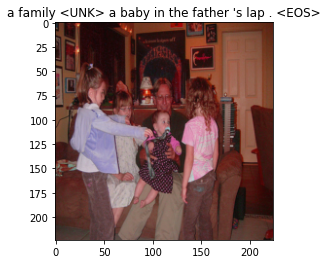

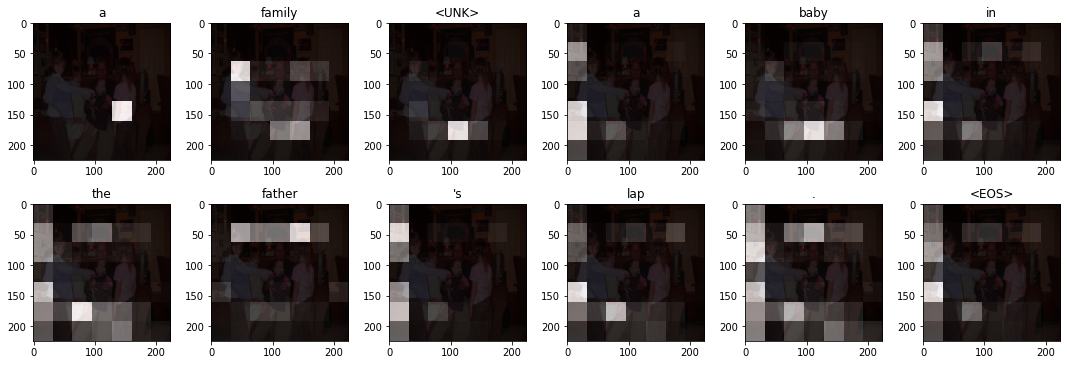

In [21]:
#show any 1
dataiter = iter(train_loader)
images, _ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)